# $\beta$'s Normality

In the following notebook we show empirical evidence that the $\beta$'s of a logistic regression model are normally distributed.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from scipy import stats

from joblib import Parallel, delayed
from tqdm import tqdm


SEED = 42
np.random.seed(SEED)

We load our example dataset

In [2]:
df = pd.read_csv("data/train_rose.csv")

X, y = df.drop(columns=["CARAVAN"]), df["CARAVAN"]

Define the number of bootstrap samples to generate

In [3]:
n_bootstraps = 1000
coef_dists = []

In [4]:
perc_bs = 0.8
n_bs = int(n_bootstraps * perc_bs)

def resample(X, y, n):
    idx = np.random.choice(X.index, size=int(n), replace=True)
    return X.loc[idx], y.loc[idx]

We start the simulation by resampling the data and fitting a logistic regression model to each resampled dataset. We then store the coefficients of the model in a list. This process is repeated 1000 times. The coefficients are then plotted as a histogram. The histogram shows the distribution of the coefficients.

In [5]:
def bootstrap_fit_model(X, y, perc_bs):
    # Calculate sample size
    sample_size = int(perc_bs * len(X))
    # Bootstrap sample
    X_sample, y_sample = resample(X, y, sample_size)
    
    # Fit logistic regression model
    model = LogisticRegression(solver="liblinear")
    model.fit(X_sample, y_sample)
    
    # Return the coefficients
    coeffs = model.intercept_.tolist() + model.coef_[0].tolist()
    
    return np.array(coeffs)

In [6]:
tasks = (delayed(bootstrap_fit_model)(X, y, perc_bs) for _ in range(n_bootstraps))
coef_dists = Parallel(n_jobs=-1)(tqdm(tasks, total=n_bootstraps, desc="Bootstrapping"))

coef_dists = np.array(coef_dists)

Bootstrapping: 100%|██████████| 1000/1000 [00:34<00:00, 28.79it/s]


In [7]:
coef_dists.shape

(1000, 56)

## Estimation of the distribution of $\hat{\beta}$

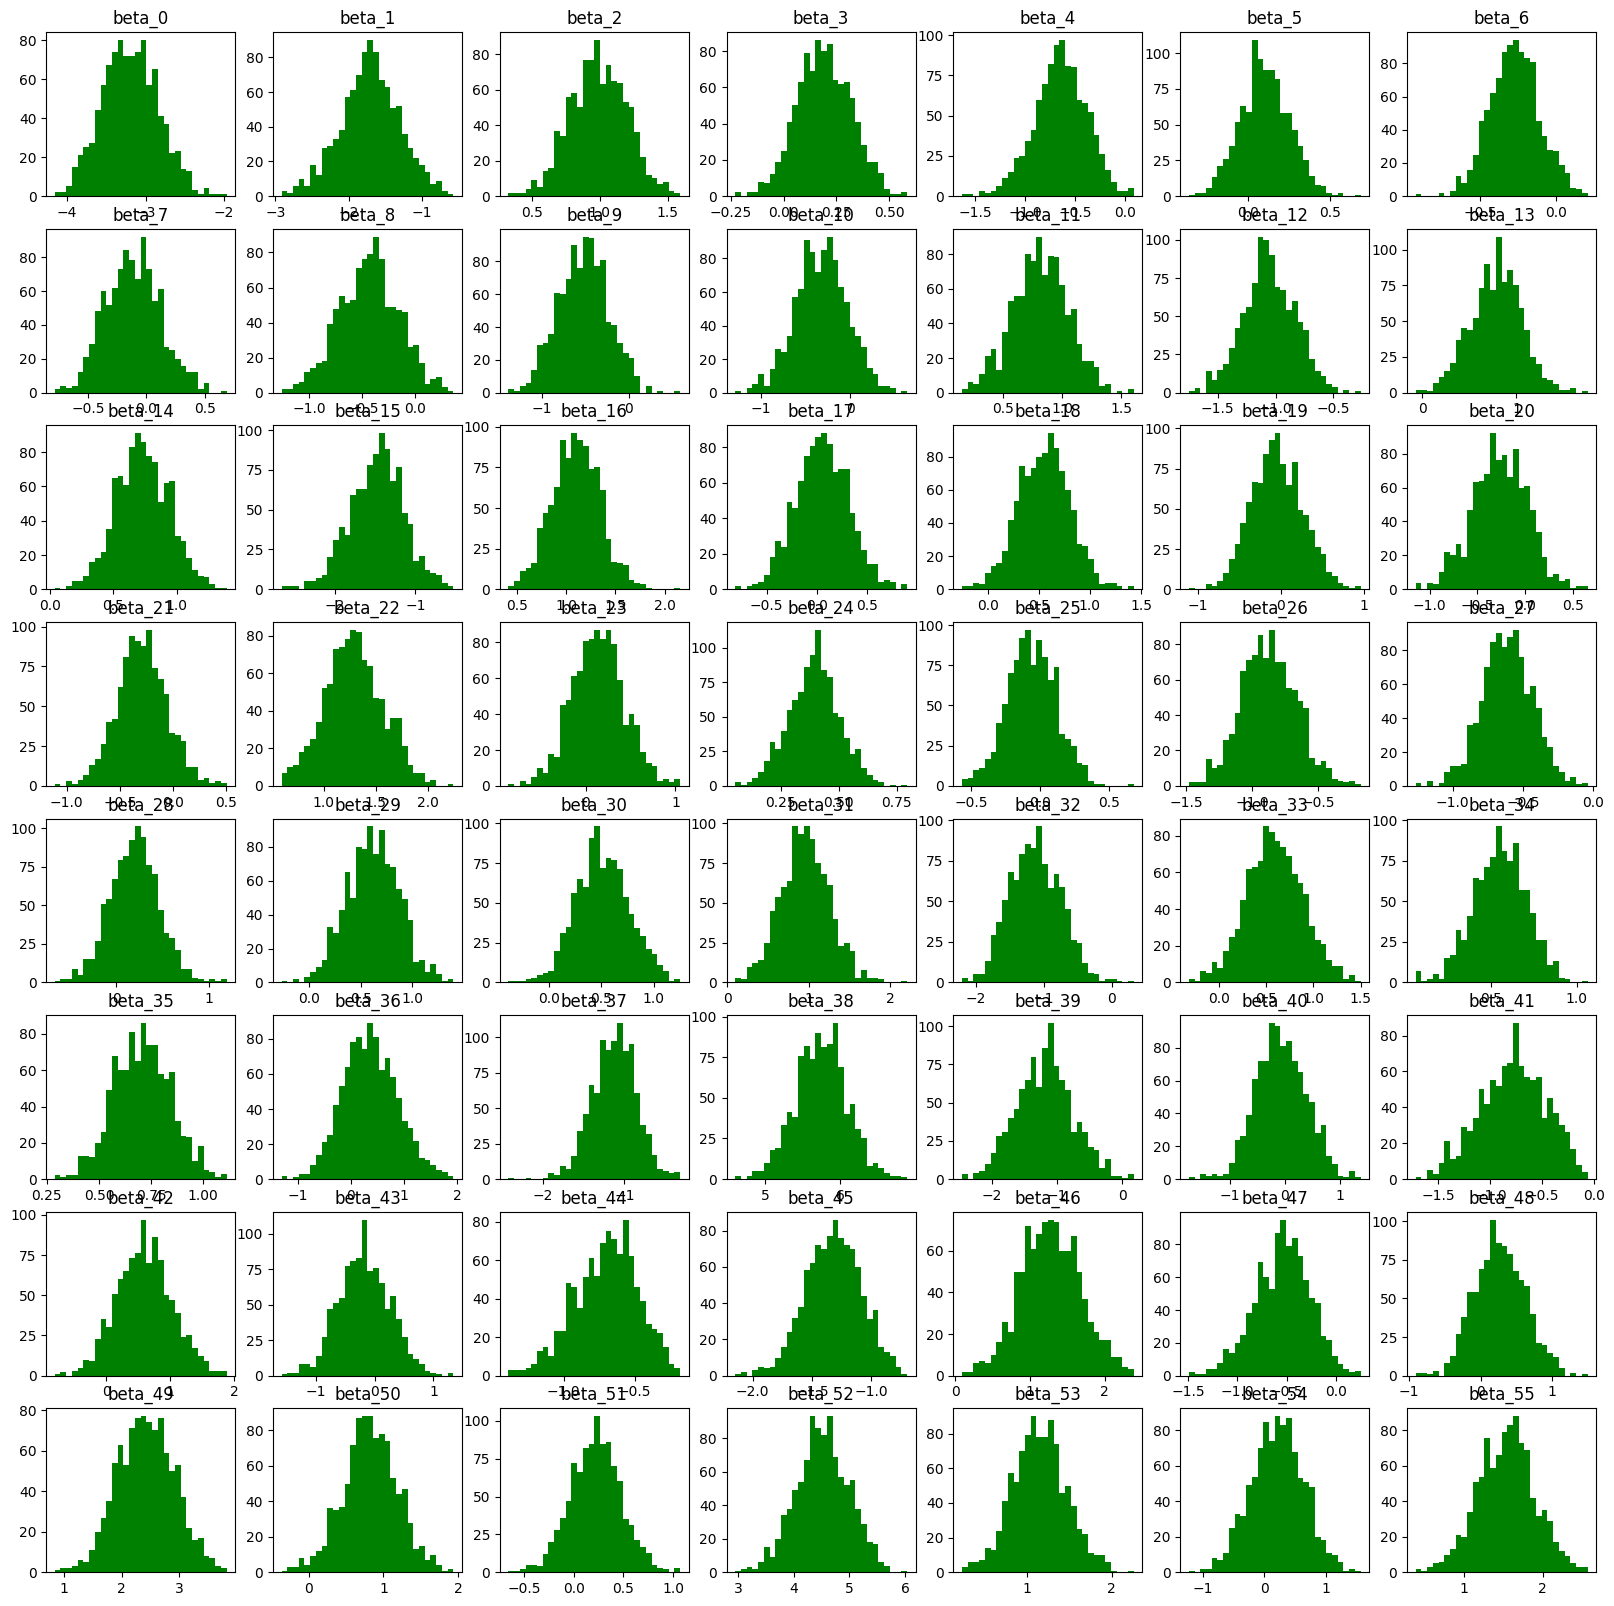

In [8]:
# Histogram of the bootstrapped betas 5 columns 10 rows
fig, ax = plt.subplots(8, 7, figsize=(20, 20))

for i in range(8):
    for j in range(7):
        _beta = coef_dists[:, i * 7 + j]
        
        ax[i, j].hist(_beta, bins=30, color="g")
        ax[i, j].set_title(f"beta_{i * 7 + j}")


## Hypothesis tests

After a visual inspection of the histogram, we can perform a more formal test to check if the coefficients are normally distributed. We will use the following test:
- Shapiro-Wilk test
- Kolmogorov-Smirnov test

In [28]:
from scipy import stats
from tabulate import tabulate

In [33]:
# Significance level 0.1%
alpha = 0.01

p_values = dict()

### Shapiro-Wilk test

In [34]:
for i in range(coef_dists.shape[1]):
    _beta = coef_dists[:, i]
    
    sq = stats.shapiro(_beta)
    ks = stats.kstest(
        (_beta - np.mean(_beta)) / np.std(_beta), "norm"
    )
    
    p_values[i] = (sq.pvalue, ks.pvalue)

In [35]:
p_values = pd.DataFrame(p_values, index=["Shapiro-Wilk", "Kolmogorov-Smirnov"]).T

In [36]:
p_values['Shapiro-Wilk Normality'] = p_values['Shapiro-Wilk'] > alpha
p_values['Kolmogorov-Smirnov Normality'] = p_values['Kolmogorov-Smirnov'] > alpha

In [37]:
print(any(p_values['Shapiro-Wilk Normality'] == False))
print(any(p_values['Kolmogorov-Smirnov Normality'] == False))

True
False


Both tests indicate that the coefficients follow a normal distribution.

## Transformation

We now consider the following transformation:

$$
Y \sim \frac{1}{1+e^{x^T\beta}}
$$

We now that $ \eta_{\beta} = e^{x^T\beta} \sim \text{Lognormal}(\mu_{\beta}, \sigma^2_{\beta}) $. However, Y does not follow a know distribution.

In [76]:
x = np.ones(coef_dists.shape[1])
eta = coef_dists @ x
y = 1 / (1 + np.exp(-eta))

In [79]:
print(f"Mean: {np.mean(y):.2f}")
print(f"Std: {np.std(y):.2f}")
print(f"Min: {np.min(y):.2f}")
print(f"Max: {np.max(y):.2f}")
print(f"Median: {np.median(y):.2f}")

Mean: 1.00
Std: 0.00
Min: 1.00
Max: 1.00
Median: 1.00


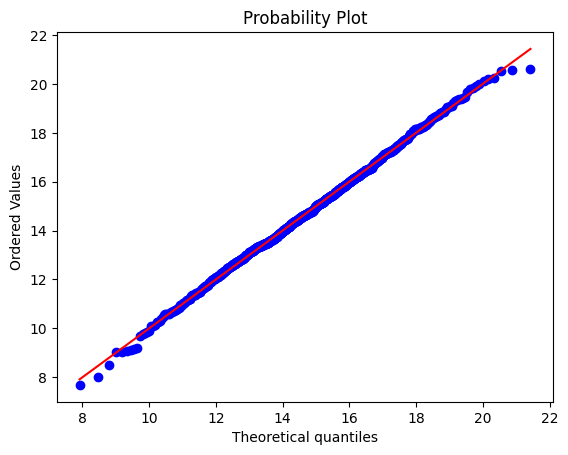

In [82]:
mu, std = np.mean(eta), np.std(eta, ddof=1)
probplot(eta, dist="norm", sparams=(mu, std), plot=plt)
plt.show()

In [62]:
alpha = 0.001

# Shapiro-Wilk test
sw = stats.shapiro(y)

# Kolmogorov-Smirnov test
ks = stats.kstest(
    (y - np.mean(y)) / np.std(y, ddof=1),
    "norm"
)

# Anderson-Darling test
ad = stats.anderson(betas_0, "norm")


# Interpret the results
print("Shapiro-Wilk test")
if sw.pvalue > alpha:
    print("Fail to reject the null hypothesis: the data is likely normally distributed.")
else:
    print("Reject the null hypothesis: the data is not likely normally distributed.")
    
print("\nKolmogorov-Smirnov test")
if ks.pvalue > alpha:
    print("Fail to reject the null hypothesis: the data is likely normally distributed.")
else:
    print("Reject the null hypothesis: the data is not likely normally distributed.")

Shapiro-Wilk test
Reject the null hypothesis: the data is not likely normally distributed.

Kolmogorov-Smirnov test
Reject the null hypothesis: the data is not likely normally distributed.
